Projet 10 : Réalisez un application de recommandation de contenu   

Contexte :  
Je suis directeur technique de l’entreprise My content, une start-up qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs.  

Demande : Réaliser une première application de recommandation de contenu

Missions : 
- Développer une première version d’un système de recommandation sous forme d’Azure Functions
- Réaliser une application simple de gestion du système de recommandation
- Stocker les scripts développés dans un dossier GitHub
- Synthétiser les premières réflexions sur l’architecture de l’application

Ce notebook concerne l'EDA et la comparaison de plusieurs approches de recommandation de contenu.  

# Import des librairies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Chargement des données

Commençons par regarder les données à notre disposition.  
Les données proviennent de kaggle et sont disponible à l'adresse : https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom#clicks_sample.csv.  
Ce sont des données provenant de l’entreprise globocom, un portail d’actualité situé au Brésil.  

In [2]:
# Chargement du jeu  de données
def charger_donnees(fichier):
    df = pd.read_csv('data/'+ fichier, sep=',')
    # Visualisation des valeurs manquantes avec msno
    msno.matrix(df)
    plt.show()
    # Afficher les dimensions
    print(f"Les dimensions du tableau : {df.shape[0]} lignes et {df.shape[1]} colonnes")
    # Afficher le nombre de doublons
    num_duplicates = df.duplicated().sum()
    print(f"Nombre de doublons dans le jeu de données : {num_duplicates}")
    # Afficher le pourcentage global de valeurs manquantes
    global_missing_percentage = (df.isnull().mean().mean()) * 100
    print(f'Pourcentage global de valeurs manquantes dans le jeu de données : {global_missing_percentage:.2f}%')
    # Afficher le nombre de colonnes complètement vides
    empty_columns = df.columns[df.isnull().all()]
    num_empty_columns = len(empty_columns)
    print(f"Nombre de colonnes complètement vides : {num_empty_columns}")
    return df

In [3]:
data_path = 'data/'
clicks_path = data_path + 'clicks/'

In [4]:
for file in os.listdir(data_path):
    print(file)

.ipynb_checkpoints
articles_embeddings.pickle
articles_metadata.csv
clicks.zip
clicks_sample.csv


Les données sont composées de 4 fichiers principaux contenant :

articles_metadata.csv : fichier CSV contenant des informations sur tous les articles publiés    
articles_embeddings.pickle : embedding des articles  
clicks : dossier avec des fichiers csv (un par heure), contenant les sessions des utilisateurs   
clicks_sample.csv : fichier CSV contenant un échantillon des sessions des utilisateurs  

# Exploration des données

Je vais maintenant regarder plus en détail les fichiers.  

## articles_metadata.csv

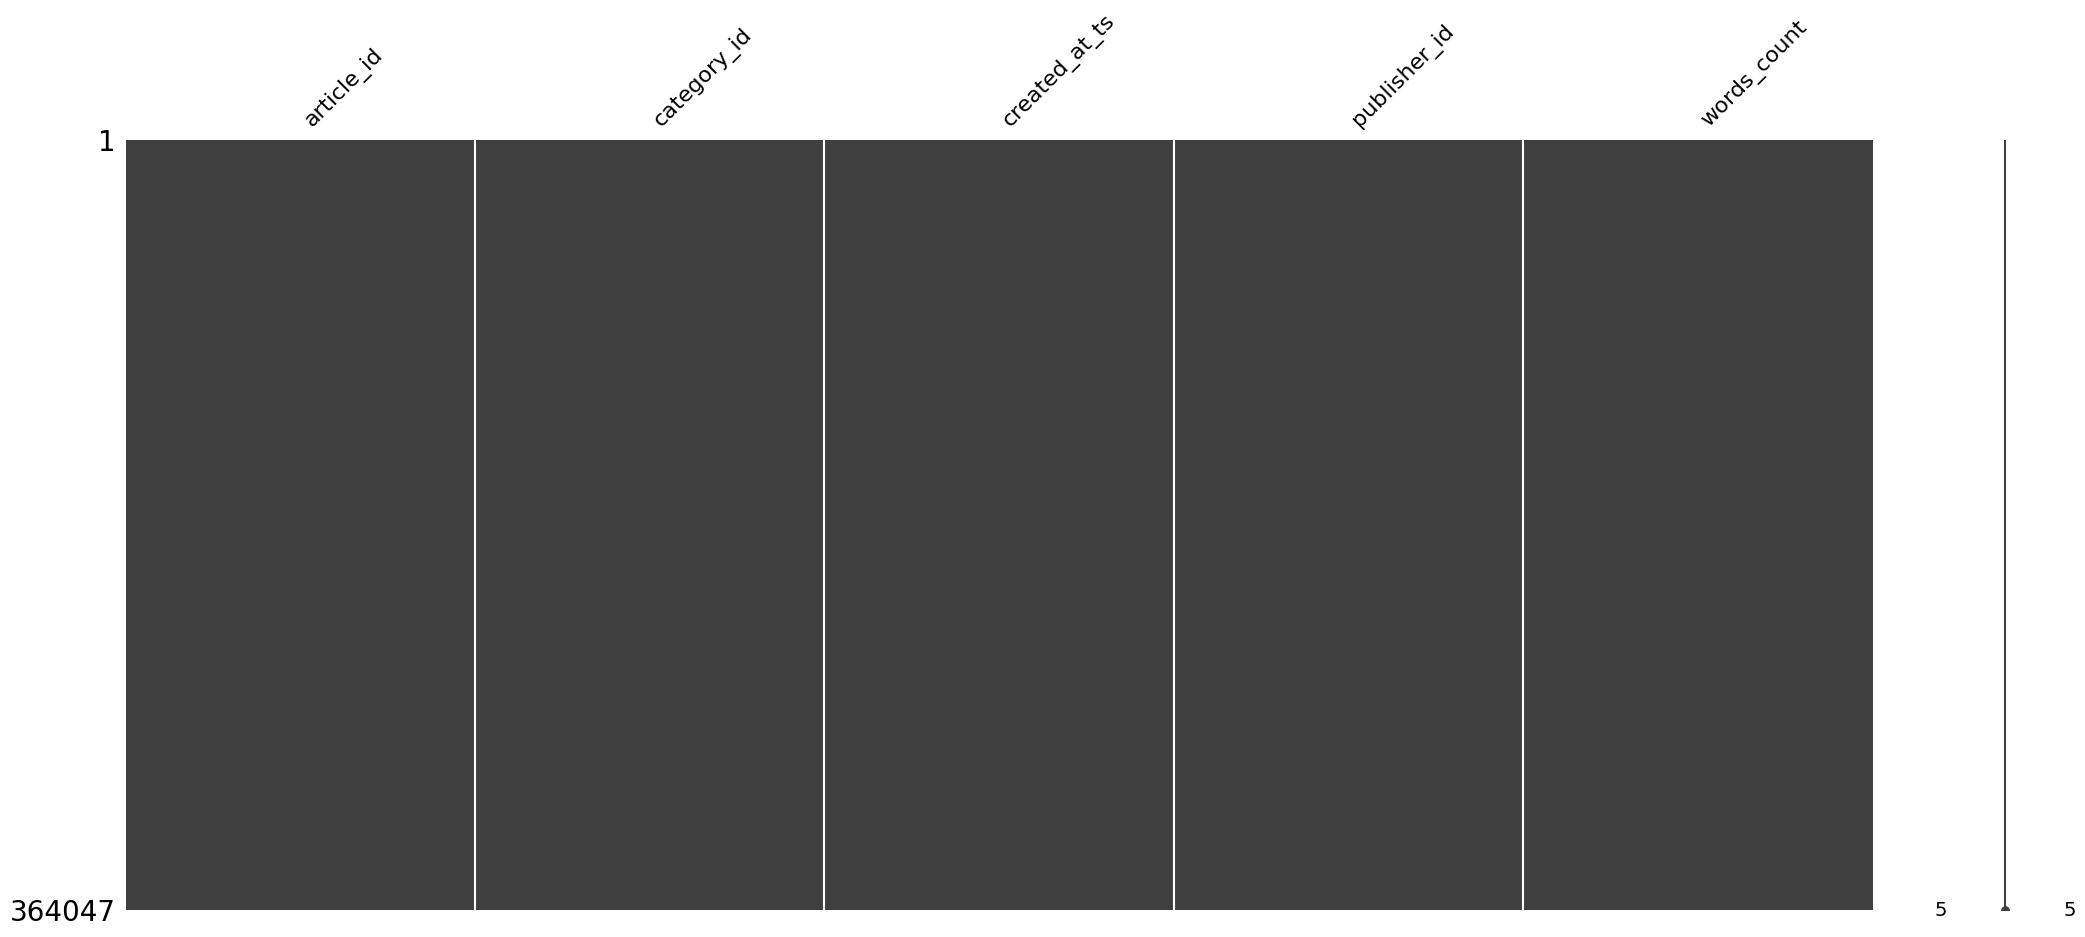

Les dimensions du tableau : 364047 lignes et 5 colonnes
Nombre de doublons dans le jeu de données : 0
Pourcentage global de valeurs manquantes dans le jeu de données : 0.00%
Nombre de colonnes complètement vides : 0


In [5]:
article_data = charger_donnees("articles_metadata.csv")

In [6]:
article_data.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [7]:
article_data.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


<function matplotlib.pyplot.show(close=None, block=None)>

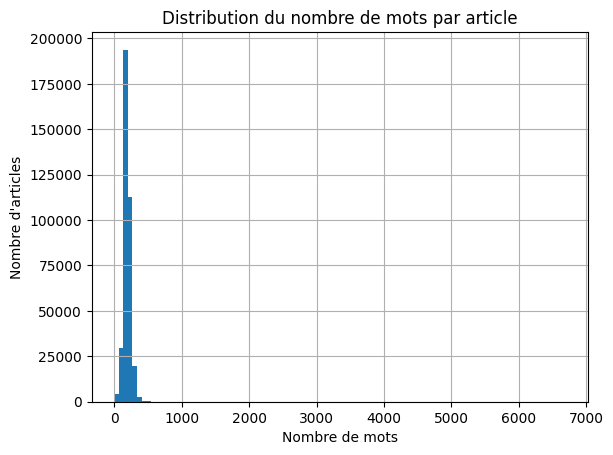

In [8]:
article_data['words_count'].hist(bins=100)
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.title("Distribution du nombre de mots par article")
plt.show

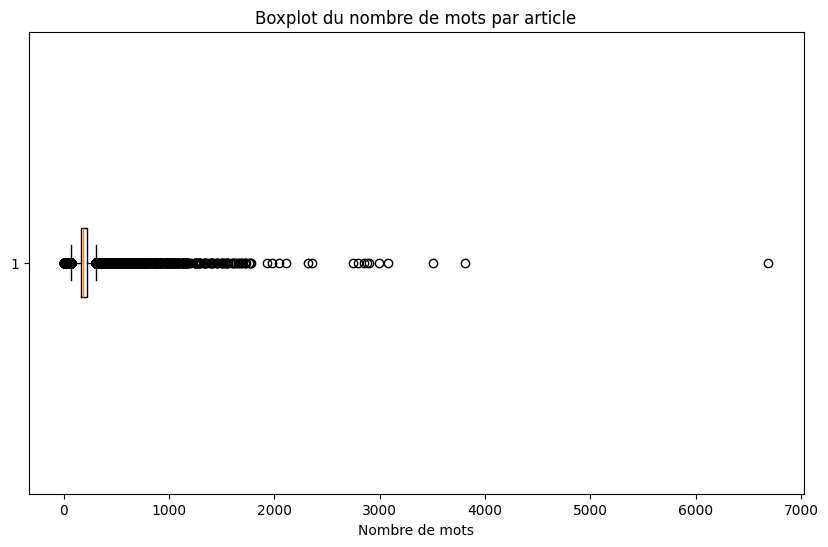

In [9]:
plt.figure(figsize=(10, 6))
plt.boxplot(article_data['words_count'], vert=False)
plt.xlabel("Nombre de mots")
plt.title("Boxplot du nombre de mots par article")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

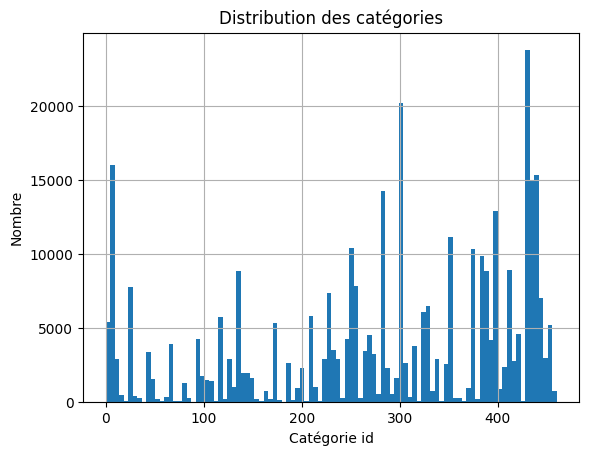

In [10]:
article_data['category_id'].hist(bins=100)
plt.xlabel("Catégorie id")
plt.ylabel("Nombre")
plt.title("Distribution des catégories")
plt.show

In [11]:
nombre_unique_cat_id = article_data['category_id'].nunique()

print(f"Il y a {nombre_unique_cat_id} de catégories dans le dataset.")

Il y a 461 de catégories dans le dataset.


## clicks_sample.csv

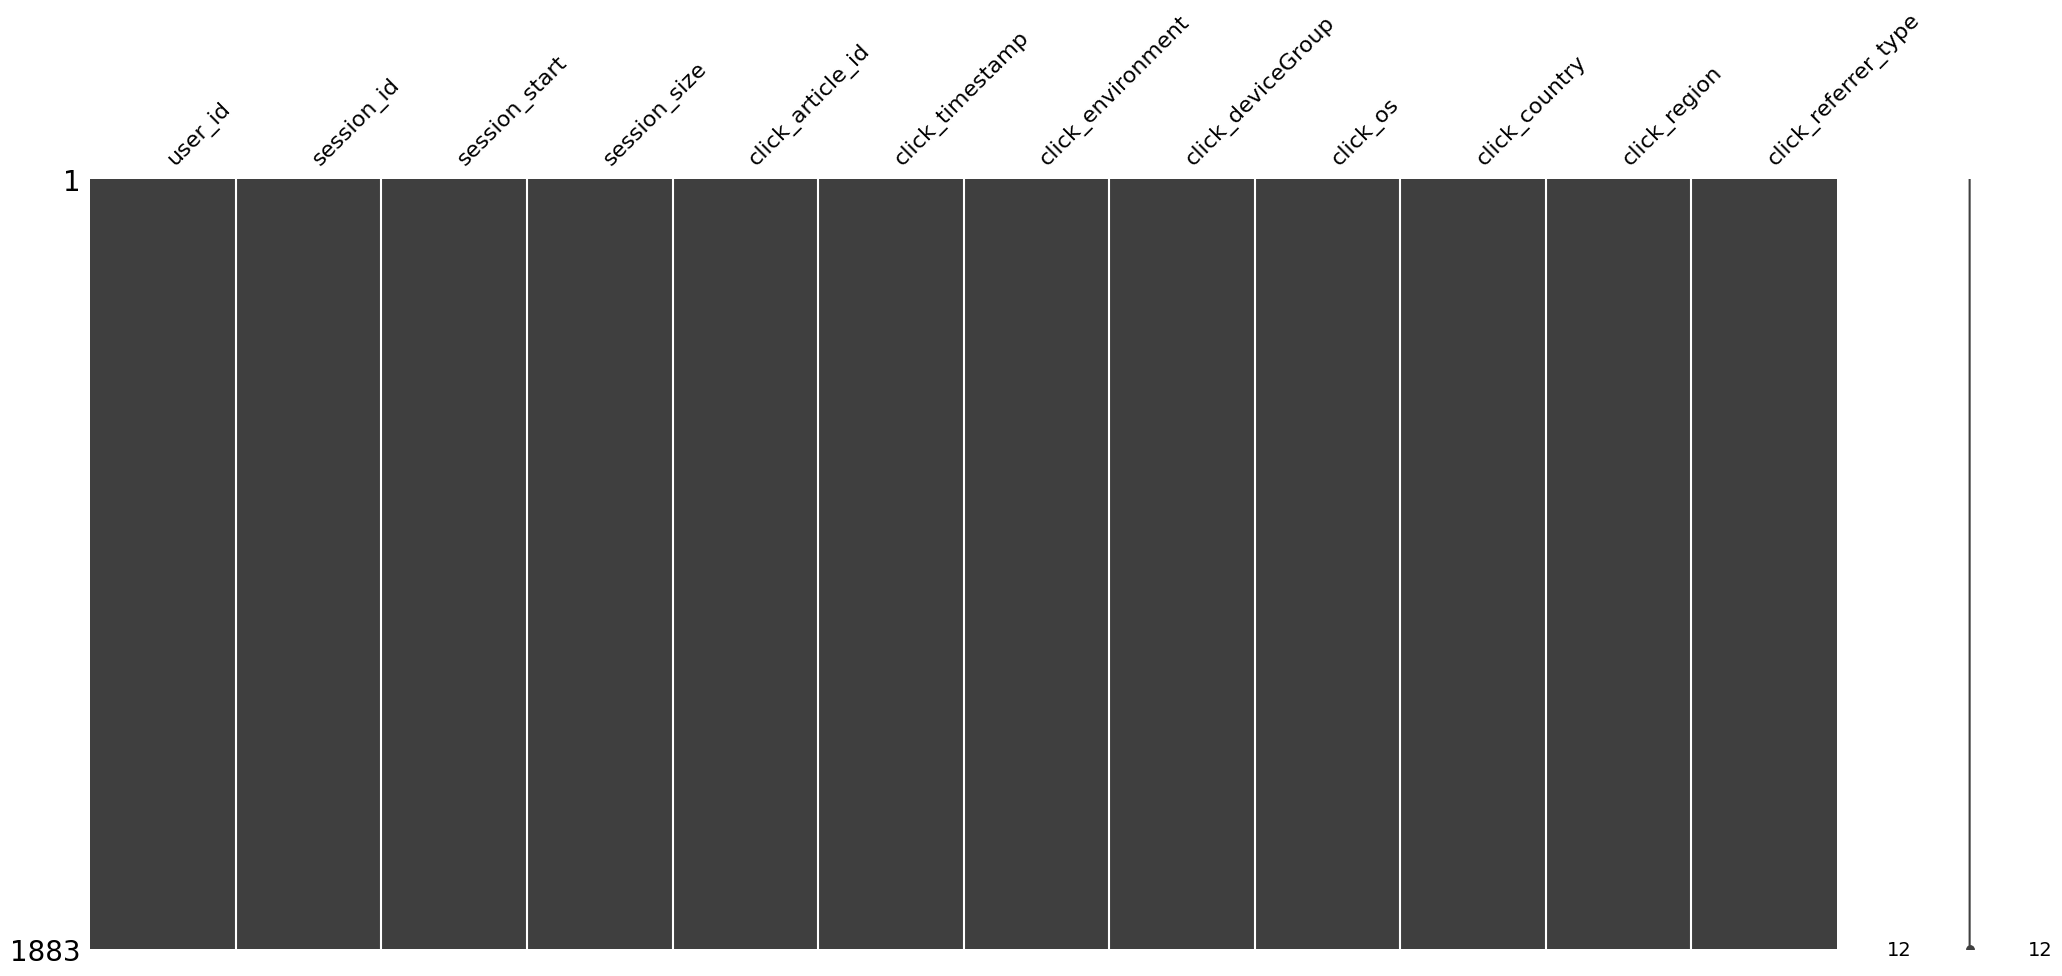

Les dimensions du tableau : 1883 lignes et 12 colonnes
Nombre de doublons dans le jeu de données : 0
Pourcentage global de valeurs manquantes dans le jeu de données : 0.00%
Nombre de colonnes complètement vides : 0


In [12]:
clicks_data = charger_donnees('clicks_sample.csv')

In [13]:
clicks_data.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [14]:
clicks_data.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1.883000e+03,1883.000000,1883.000000,1.883000e+03,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,1.506828e+12,3.459904,176717.848646,1.506830e+12,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
std,206.162865,8.679628e+08,8.679468e+05,3.037467,82324.177259,1.064938e+07,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679
min,0.000000,1.506825e+15,1.506825e+12,2.000000,2137.000000,1.506827e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,1.506827e+12,2.000000,108854.000000,1.506828e+12,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,1.506828e+12,3.000000,157541.000000,1.506828e+12,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,1.506828e+12,4.000000,236697.500000,1.506829e+12,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,1.506829e+12,24.000000,363291.000000,1.506998e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


Le fichier clicks_sample.csv est uniquement un échantillon de session d'utilisateur.  
Nous n'allons pas utiliser ce fichier pour ce projet, le fichier complet est présent dans clicks.zip.  

## cliks.zip

Ce fichier contient toutes les informations sur les sessions utilisateurs (heure par heure).
C'est lui qui va nous servir pour le projet.  
Commençons par merger les fichiers présent dans le zip pour les utiliser dans la suite du projet.  

In [15]:
import glob

# Décompressez d'abord le fichier zip
import zipfile
with zipfile.ZipFile('data/clicks.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Obtenez une liste de tous les fichiers csv
all_files = glob.glob('./clicks/clicks_hour_*.csv')

# Créez une liste pour stocker vos données
li = []

# Parcourez tous les fichiers et lisez-les dans un dataframe pandas
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concaténez tous les dataframes ensemble
frame = pd.concat(li, axis=0, ignore_index=True)

# Enregistrez le dataframe final dans un nouveau fichier csv
frame.to_csv("data/clicks_combined.csv", index=False)

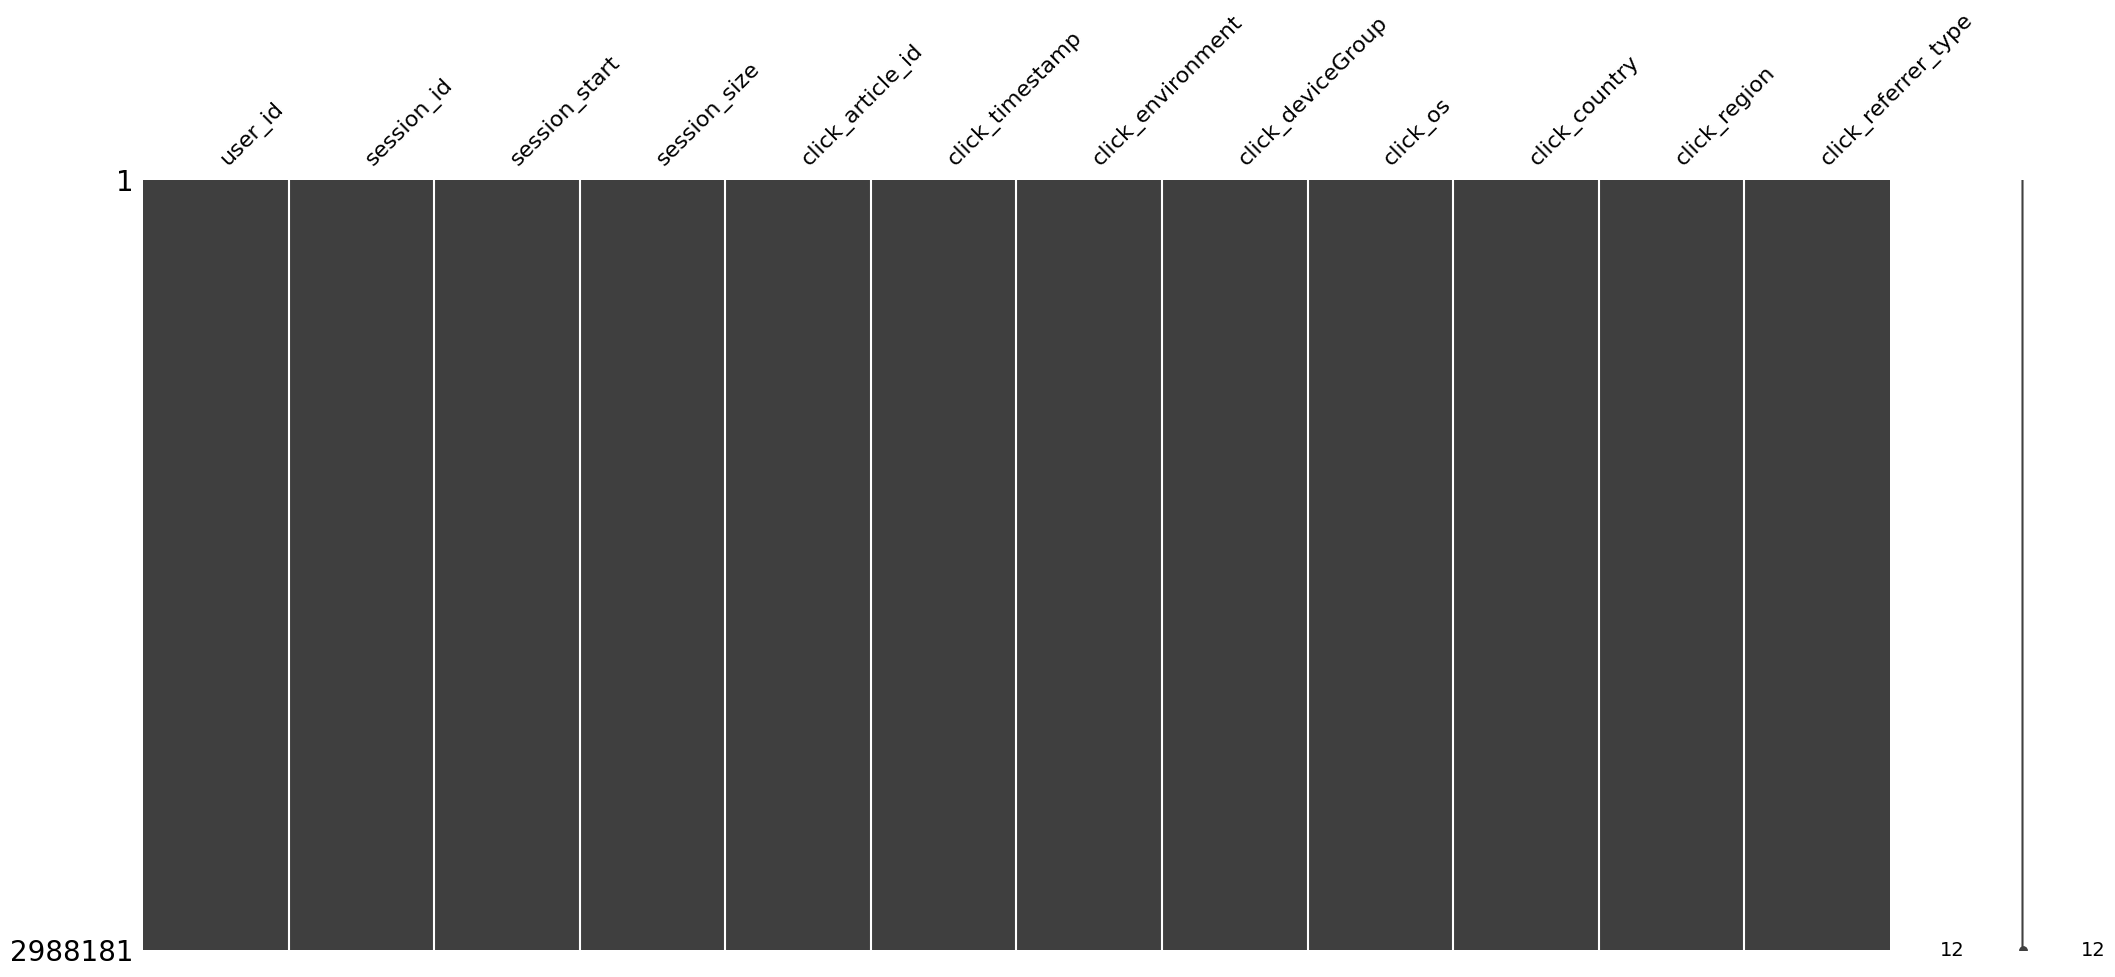

Les dimensions du tableau : 2988181 lignes et 12 colonnes
Nombre de doublons dans le jeu de données : 0
Pourcentage global de valeurs manquantes dans le jeu de données : 0.00%
Nombre de colonnes complètement vides : 0


In [16]:
clicks_comb = charger_donnees('clicks_combined.csv')

In [17]:
clicks_comb.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [18]:
clicks_comb.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


In [19]:
nombre_unique_user_id = clicks_comb['user_id'].nunique()

print(f"Il y a {nombre_unique_user_id} utilisateurs dans le dataset.")

Il y a 322897 utilisateurs dans le dataset.


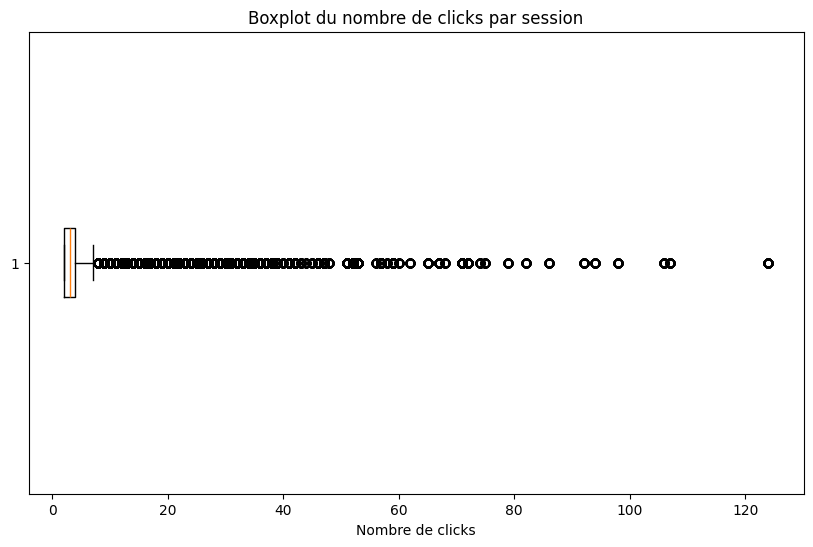

In [20]:
plt.figure(figsize=(10, 6))
plt.boxplot(clicks_comb['session_size'], vert=False)
plt.xlabel("Nombre de clicks")
plt.title("Boxplot du nombre de clicks par session")
plt.show()

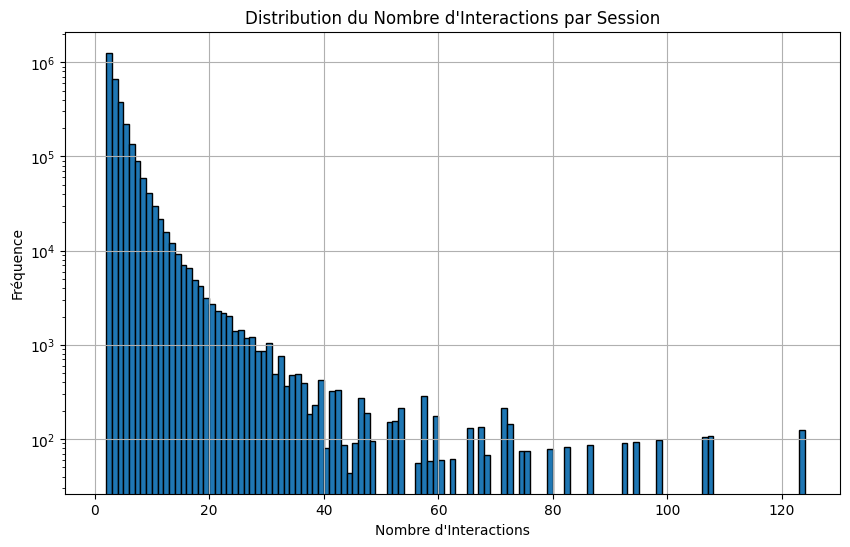

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(clicks_comb['session_size'], bins=range(1, 125), edgecolor='black')
plt.title('Distribution du Nombre d\'Interactions par Session')
plt.xlabel('Nombre d\'Interactions')
plt.ylabel('Fréquence')
plt.yscale('log')
plt.grid(True)
plt.show()

J'ai voulu ensuite regarder la durée des sessions utilisateur.  
J'ai commencé par calculer la durée des sessions puis je les ai transformé en heure pour une meilleure compréhension.  

In [22]:
import pandas as pd

clicks_comb['session_start'] = pd.to_datetime(clicks_comb['session_start'], unit='ms')
clicks_comb['click_timestamp'] = pd.to_datetime(clicks_comb['click_timestamp'], unit='ms')

# Calculer la durée de chaque session
clicks_comb['session_duration'] = clicks_comb.groupby('session_id')['click_timestamp'].transform('max') - clicks_comb['session_start']

# Convertir en secondes
clicks_comb['session_duration_seconds'] = clicks_comb['session_duration'].dt.total_seconds()

# Convertir en minutes
clicks_comb['session_duration_minutes'] = clicks_comb['session_duration_seconds'] / 60

# Convertir en heures
clicks_comb['session_duration_hours'] = clicks_comb['session_duration_seconds'] / 3600

# Afficher les statistiques descriptives
print(clicks_comb['session_duration_hours'].describe())

count    2.988181e+06
mean     8.300043e-01
std      6.944764e+00
min      8.333333e-03
25%      3.577750e-02
50%      1.234572e-01
75%      4.142119e-01
max      6.722966e+02
Name: session_duration_hours, dtype: float64


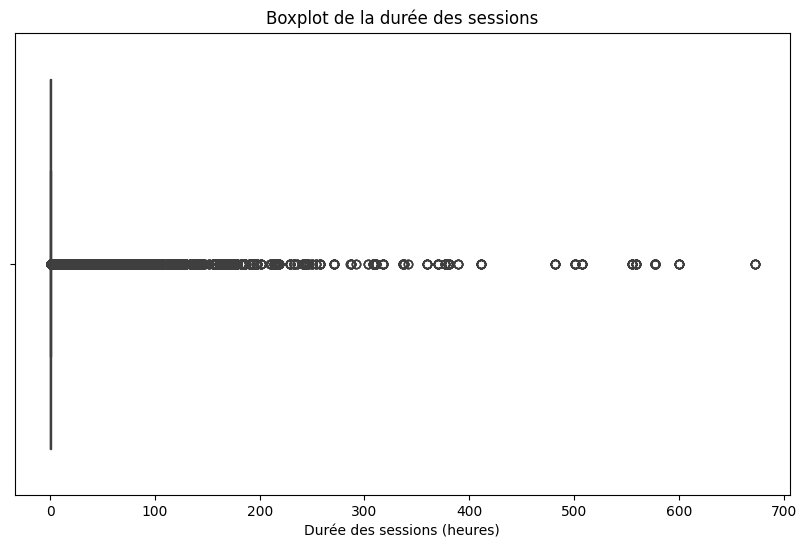

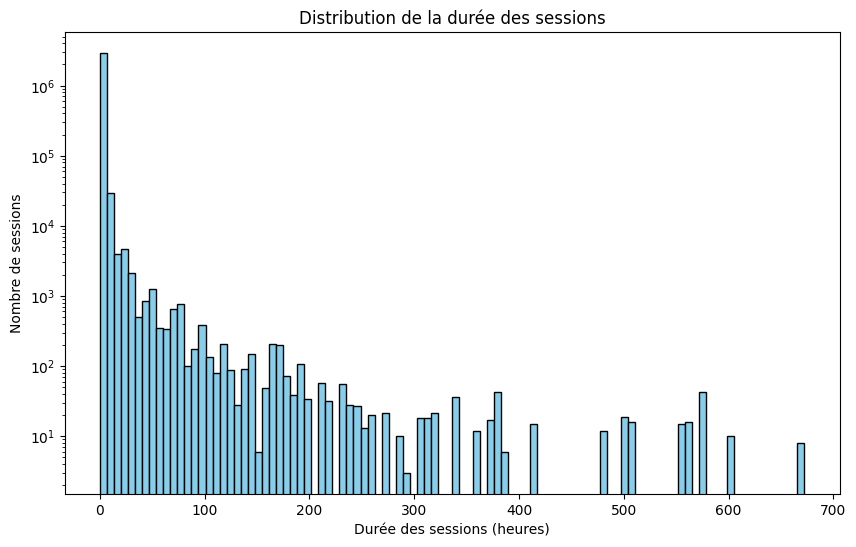

In [23]:
# Boxplot pour visualiser les valeurs aberrantes
plt.figure(figsize=(10, 6))
sns.boxplot(x=clicks_comb['session_duration_hours'])
plt.title('Boxplot de la durée des sessions')
plt.xlabel('Durée des sessions (heures)')
plt.show()

# Histogramme pour visualiser la distribution
plt.figure(figsize=(10, 6))
plt.hist(clicks_comb['session_duration_hours'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution de la durée des sessions')
plt.xlabel('Durée des sessions (heures)')
plt.ylabel('Nombre de sessions')
plt.yscale('log')
plt.show()

## Articles_embeddings

Ce fichier est un peu particulier.  
C'est un fichier contenant les vecteurs d'embedding pour chaque article présent dans le jeu de données.  
Nous n'avons pas toutes les informations permettant de le recréer mais nous pouvons l'utiliser en recréant un dataframe à partir du fichier pickle.  

In [24]:
articles_emb = pd.read_pickle(data_path + 'articles_embeddings.pickle')

In [25]:
articles_emb = pd.DataFrame(articles_emb, columns=["embedding_" + str(i) for i in range(articles_emb.shape[1])])
articles_emb.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [26]:
articles_emb.shape

(364047, 250)

# Nettoyage

Au cours de l'exploration des fichiers, nous avons pu mettre en évidence certaines valeurs qui semblent aberrantes.  
Je vais effectuer un nettoyage des valeurs qui me semblent les plus aberrantes pour pouvoir travailler sur un jeu de données propres.  

In [27]:
# Vérifier si tous les indices correspondent
indices_match = all(article_data.index == articles_emb.index)

print(f"Les indices correspondent-ils ? {indices_match}")

Les indices correspondent-ils ? True


On commence par retirer les articles avec 0 mot puis on retire également ces articles du fichier d'embeddings.  

In [28]:
# Enregistrer la taille originale du DataFrame
original_size = len(article_data)

# Trouver les indices des articles avec 0 mot
indices = article_data[article_data['words_count'] == 0].index

# Retirer ces articles
article_data = article_data.drop(indices)

# Retirer les embeddings correspondants
articles_emb = articles_emb.drop(indices)

# Calculer le nombre d'articles retirés
removed_articles = original_size - len(article_data)

print(f"Nombre d'articles retirés : {removed_articles}")

Nombre d'articles retirés : 35


On retire les sessions de plus de 24h dans le fichiers clicks.  
J'ai choisi arbitrairement 24h comme limite haute, au delà je considère les valeurs comme des valeurs aberrantes.  

In [29]:
# Enregistrer la taille originale du DataFrame
original_size = len(clicks_comb)

# Filtrer les sessions qui dépassent 24 heures
clicks_comb = clicks_comb[clicks_comb['session_duration_hours'] <= 24]

# Calculer le nombre de sessions retirées
removed_sessions = original_size - len(clicks_comb)

print(f"Nombre de sessions retirées : {removed_sessions}")

Nombre de sessions retirées : 11496


In [30]:
article_data.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364012.00000,364012.000000,3.640120e+05,364012.0,364012.000000
mean,182015.71710,283.100233,1.474075e+12,0.0,190.916082
std,105090.12104,136.722705,4.292641e+10,0.0,59.476174
min,0.00000,0.000000,1.159356e+12,0.0,5.000000
25%,91006.75000,199.000000,1.444930e+12,0.0,159.000000
50%,182010.50000,301.000000,1.489424e+12,0.0,186.000000
75%,273021.25000,399.000000,1.509892e+12,0.0,218.000000
max,364046.00000,460.000000,1.520943e+12,0.0,6690.000000


In [31]:
nombre_unique_user_id = clicks_comb['user_id'].nunique()

print(f"Il y a {nombre_unique_user_id} utilisateurs dans le dataset.")

Il y a 322627 utilisateurs dans le dataset.


In [32]:
clicks_comb.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,session_duration,session_duration_seconds,session_duration_minutes,session_duration_hours
count,2.976685e+06,2.976685e+06,2976685,2.976685e+06,2.976685e+06,2976685,2.976685e+06,2.976685e+06,2.976685e+06,2.976685e+06,2.976685e+06,2.976685e+06,2976685,2.976685e+06,2.976685e+06,2.976685e+06
mean,1.080002e+05,1.507472e+15,2017-10-08 14:18:09.318302720,3.859781e+00,1.949309e+05,2017-10-08 14:41:46.420856576,3.942434e+00,1.822281e+00,1.326370e+01,1.356962e+00,1.831211e+01,1.838649e+00,0 days 00:32:38.518478525,1.958518e+03,3.264197e+01,5.440329e-01
min,0.000000e+00,1.506825e+15,2017-10-01 02:37:03,2.000000e+00,3.000000e+00,2017-10-01 03:00:00.026000,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0 days 00:00:30,3.000000e+01,5.000000e-01,8.333333e-03
25%,4.031000e+04,1.507124e+15,2017-10-04 13:37:08,2.000000e+00,1.242280e+05,2017-10-04 14:16:11.108999936,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,0 days 00:02:08.123000,1.281230e+02,2.135383e+00,3.558972e-02
50%,8.632500e+04,1.507493e+15,2017-10-08 20:10:05,3.000000e+00,2.023810e+05,2017-10-08 20:24:59.169999872,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,0 days 00:07:20.427000,4.404270e+02,7.340450e+00,1.223408e-01
75%,1.633810e+05,1.507749e+15,2017-10-11 19:17:40,4.000000e+00,2.770670e+05,2017-10-11 19:40:34.022000128,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,0 days 00:24:28.235000,1.468235e+03,2.447058e+01,4.078431e-01
max,3.228960e+05,1.508211e+15,2017-10-17 03:36:19,1.240000e+02,3.640460e+05,2017-10-18 00:59:45.692000,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,0 days 23:59:47.958000,8.638796e+04,1.439799e+03,2.399666e+01
std,8.367500e+04,3.855111e+11,NaN,3.743679e+00,9.076322e+04,NaN,3.403047e-01,1.042945e+00,6.890968e+00,1.724058e+00,7.064839e+00,1.155819e+00,0 days 01:28:21.908909653,5.301909e+03,8.836515e+01,1.472752e+00


On sauvegarde les fichiers nettoyé pour pouvoir les utiliser par la suite.  

In [33]:
# Sauvegarder le DataFrame article_data
article_data.to_csv('article_data_clean.csv', index=False)

# Sauvegarder les embeddings articles_emb
articles_emb.to_pickle('articles_embeddings_clean.pickle')

# Sauvegarder le DataFrame clicks_comb
clicks_comb.to_csv('clicks_comb_clean.csv', index=False)

# Content-Based

Voici plusieurs algorithmes basé sur le Content-Based. Ces approches cherchent à définir les articles non lus qui devraient plaire également à l'utilisateur en se basant sur les articles lus par les utilisateurs.  

On utilise pour cela la similarité cosinus.  

## Recommandations à partir du dernier article lu

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top5_articles(user_id, clicks_comb, articles_emb, article_data):
    # Trouver l'article le plus récemment cliqué par l'utilisateur
    user_clicks = clicks_comb[clicks_comb['user_id'] == user_id]
    last_clicked_article = user_clicks.sort_values('click_timestamp', ascending=False)['click_article_id'].values[0]
    
    # Obtenir l'embedding de cet article
    last_clicked_article_emb = articles_emb.loc[last_clicked_article]
    
    # Calculer la similarité cosinus entre cet article et tous les autres
    similarities = cosine_similarity([last_clicked_article_emb], articles_emb)[0]
    
    # Obtenir les indices des 5 articles les plus similaires
    top5_article_indices = similarities.argsort()[-6:-1][::-1]  # -6:-1 pour exclure l'article lui-même
    
    # Retourner les données de ces articles
    top5_articles = article_data.loc[top5_article_indices]
    
    return top5_articles

In [35]:
# Utilisation de la fonction
top5_articles = get_top5_articles(user_id=0, clicks_comb=clicks_comb, articles_emb=articles_emb, article_data=article_data)
print(top5_articles)

       article_id  category_id  created_at_ts  publisher_id  words_count
87274       87274          186  1510522950000             0          116
86139       86139          186  1434926318000             0          107
87672       87672          187  1459720013000             0           97
87026       87026          186  1501457501000             0          149
87423       87423          186  1517179663000             0          108


## Recommandations à partir des 10 articles les plus vue par l'utilisateur

In [36]:
def get_similar_articles(user_id, clicks_comb, articles_emb, article_data, n_articles=10, n_similar=5):
    # Obtenir les articles les plus vus par l'utilisateur
    user_clicks = clicks_comb[clicks_comb['user_id'] == user_id]
    top_articles = user_clicks['click_article_id'].value_counts().index[:n_articles]
    
    similar_articles = []
    
    for article_id in top_articles:
        # Obtenir l'embedding de l'article
        article_emb = articles_emb.loc[article_id]
        
        # Calculer la similarité cosinus entre cet article et tous les autres
        similarities = cosine_similarity([article_emb], articles_emb)[0]
        
        # Obtenir les indices des 5 articles les plus similaires
        similar_article_indices = similarities.argsort()[-n_similar-1:-1][::-1]  # -n_similar-1:-1 pour exclure l'article lui-même
        
        similar_articles.extend(similar_article_indices)
    
    # Sélectionner aléatoirement 5 articles parmi la liste
    recommended_articles = np.random.choice(similar_articles, size=5, replace=False)
    
    # Retourner les données de ces articles
    recommended_articles_data = article_data.loc[recommended_articles]
    
    return recommended_articles_data

In [37]:
recommended_articles = get_similar_articles(user_id=0, clicks_comb=clicks_comb, articles_emb=articles_emb, article_data=article_data)
print(recommended_articles)

        article_id  category_id  created_at_ts  publisher_id  words_count
86380        86380          186  1456700057000             0          138
105554      105554          228  1483566505000             0          185
314372      314372          431  1498468182000             0          212
159280      159280          281  1482851118000             0          197
157947      157947          281  1505651250000             0          278


## Recommandations à partir des 50 articles les plus consultés

In [38]:
def get_most_similar_articles(user_id, clicks_comb, articles_emb, article_data, n_articles=50):
    # Obtenir les articles les plus vus par l'utilisateur
    user_clicks = clicks_comb[clicks_comb['user_id'] == user_id]
    top_articles = user_clicks['click_article_id'].value_counts().index[:n_articles]
    
    most_similar_articles = []
    
    for article_id in top_articles:
        # Obtenir l'embedding de l'article
        article_emb = articles_emb.loc[article_id]
        
        # Calculer la similarité cosinus entre cet article et tous les autres
        similarities = cosine_similarity([article_emb], articles_emb)[0]
        
        # Obtenir l'indice de l'article le plus similaire
        most_similar_article_index = similarities.argsort()[-2]  # -2 pour exclure l'article lui-même
        
        most_similar_articles.append(most_similar_article_index)
    
    # Sélectionner aléatoirement 5 articles parmi la liste
    recommended_articles = np.random.choice(most_similar_articles, size=5, replace=False)
    
    # Retourner les données de ces articles
    recommended_articles_data = article_data.loc[recommended_articles]
    
    return recommended_articles_data

In [39]:
# Utilisation de la fonction
recommended_articles = get_most_similar_articles(user_id=0, clicks_comb=clicks_comb, articles_emb=articles_emb, article_data=article_data)
print(recommended_articles)

        article_id  category_id  created_at_ts  publisher_id  words_count
157510      157510          281  1512885691000             0          345
92423        92423          209  1411116412000             0          304
233375      233375          375  1478866551000             0          162
313981      313981          431  1519727644000             0          188
358002      358002          450  1504008463000             0          195


Ces approches sont rapides et efficace mais elles sont dépendantes du nobmre d'article lu pour un utilisateur donné.  

# Collaborative Filtering

Le Collaborative Filtering est une approche permettant de prendre en compte les préférences des autres utilisateurs.  
Pour cela j'ai utilisé la librairie surprise et j'ai commencé par construire une matrice utilisable pour les modèles.  
Pour utiliser les modèles, j'ai besoin de 3 choses :
- Les ID utilisateurs
- Les ID articles
- Un rating score

J'ai commencé par construire cette mattrice et calculer le rating score. Ici j'ai pris le nombre de click par article sur le nombre total de click des utilisateurs.  

In [40]:
# Calculer le nombre total de clics par utilisateur
total_clicks_by_user = clicks_comb.groupby('user_id').size()

# Calculer le nombre de clics par article et par utilisateur
clicks_by_article_user = clicks_comb.groupby(['user_id', 'click_article_id']).size()

# Créer un nouveau DataFrame à partir de clicks_by_article_user
clicks_df = clicks_by_article_user.reset_index(name='clicks_per_article')

# Ajouter une nouvelle colonne au DataFrame pour le nombre total de clics par utilisateur
clicks_df['total_clicks_by_user'] = clicks_df['user_id'].map(total_clicks_by_user)

# Calculer le ratio
clicks_df['rating'] = clicks_df['clicks_per_article'] / clicks_df['total_clicks_by_user']

In [41]:
clicks_df.head()

,user_id,click_article_id,clicks_per_article,total_clicks_by_user,rating
0,0,68866,1,8,0.125
1,0,87205,1,8,0.125
2,0,87224,1,8,0.125
3,0,96755,1,8,0.125
4,0,157541,1,8,0.125


In [42]:
clicks_df.shape

(2939344, 5)

## Comparaison de plusieurs modèles

Nous allons chercher à prédire le rating des utilisateurs en fonctions des articles qu'ils ont lu et le rating des autres utilisateurs.  
J'ai comparé 3 modèles permettant ce genre de chose.

Singular Value Decomposition (SVD) : Méthode de réduction de dimensionnalité qui décompose une matrice en trois autres matrices. Le modèle prend une matrice et la divise en trois matrices plus petites qui, lorsqu’elles sont multipliées ensemble, reconstituent la matrice d’origine.  

CoClustering : Méthode de classification croisée qui permet de regrouper simultanément les lignes et les colonnes d’une matrice de données. Le modèle cherche a identifier des blocs de données similaires dans une matrice, ce qui peut être utile pour découvrir des structures sous-jacentes dans les données.  

Non-Negative Matrix Factorization (NMF) : Technique de factorisation de matrice qui décompose une matrice en deux matrices plus petites avec la contrainte que toutes les valeurs dans ces matrices doivent être non négatives. Cette méthode est souvent utilisée pour la réduction de dimensionnalité, la séparation de sources et l’extraction de sujets.  

In [43]:
from surprise import Reader, Dataset, SVD, NMF, CoClustering
from surprise.model_selection import cross_validate
import pandas as pd

# Créer un objet Reader
reader = Reader(rating_scale=(clicks_df['rating'].min(), clicks_df['rating'].max()))

# Charger les données complètes dans un objet Dataset
data = Dataset.load_from_df(clicks_df[['user_id', 'click_article_id', 'rating']], reader)


# Définir les modèles à comparer
models = {
    'SVD': SVD(),
    'CoClustering': CoClustering(),
    'NMF': NMF()
}

# Effectuer la validation croisée pour chaque modèle et stocker les résultats
results = {}
for model_name, model in models.items():
    cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    results[model_name] = cv_results

# Convertir les résultats en DataFrame 
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df[['test_rmse', 'test_mae']].map(lambda x: x.mean())

print(results_df)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1750  0.1744  0.1750  0.1745  0.1750  0.1748  0.0003  
MAE (testset)     0.1475  0.1471  0.1475  0.1471  0.1475  0.1473  0.0002  
Fit time          22.47   22.89   22.94   22.90   22.87   22.81   0.17    
Test time         4.37    4.28    3.63    4.25    4.28    4.16    0.27    
Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1647  0.1644  0.1647  0.1642  0.1646  0.1645  0.0002  
MAE (testset)     0.1071  0.1069  0.1070  0.1068  0.1071  0.1070  0.0001  
Fit time          62.36   63.11   63.40   63.16   63.61   63.13   0.42    
Test time         5.02    2.96    4.04    4.07    4.12    4.04    0.65    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE

En comparant les score RMSE et MAE des 3 modèles, on s'apperçoit que le modèle NMF semble avoir les meilleures performances sur nos données.  
Nous pouvons maintenant passer à l'optimisation des hyperparamètre du modèle NMF.  

## Optimisation des hyperparamètres

Avant d'aller plus loin et faire des prédiction avec le modèle NMF, j'ai voulu optimiser plusieurs hyperparamètres :

- n_epochs : Le nombre d’époques, c’est-à-dire le nombre de fois que l’algorithme parcourt l’ensemble des données d’entraînement. Des valeurs plus élevées peuvent permettre un meilleur ajustement du modèle, mais peuvent aussi augmenter le risque de surapprentissage.

- n_factors : Le nombre de facteurs latents. Les facteurs latents sont des dimensions cachées qui expliquent les interactions entre les utilisateurs et les articles. Un nombre plus élevé de facteurs peut capturer plus de nuances dans les données, mais cela peut aussi rendre le modèle plus complexe et augmenter le risque de surapprentissage.

- reg_pu : Paramètre de régularisation qui contrôle la pénalisation des valeurs extrêmes des vecteurs utilisateurs (pu). La régularisation est utilisée pour éviter le surapprentissage en ajoutant une pénalité pour les valeurs de paramètres trop grandes. Des valeurs plus élevées de régularisation rendent le modèle plus robuste en réduisant la variance.
  
- reg_qi : Paramètre de régularisation qui contrôle la pénalisation des valeurs extrêmes des vecteurs items (qi). Comme pour reg_pu, cela aide à éviter le surapprentissage en pénalisant les valeurs extrêmes des paramètres des items. Une régularisation plus élevée peut aider à améliorer la généralisation du modèle.

In [44]:
from surprise import Reader, Dataset, NMF
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split

# Séparer les données en un ensemble pour la recherche de grille (20%) et un ensemble pour l'entraînement final (80%)
grid_search_df, final_train_df = train_test_split(clicks_df, test_size=0.8, random_state=42)

# Créer un objet Reader
reader = Reader(rating_scale=(clicks_df['rating'].min(), clicks_df['rating'].max()))

# Charger les données pour la recherche de grille
grid_search_data = Dataset.load_from_df(grid_search_df[['user_id', 'click_article_id', 'rating']], reader)

# Définir la grille de paramètres à optimiser
param_grid = {
    'n_epochs': [5, 10, 20], 
    'n_factors': [10, 20, 50],
    'reg_pu': [0.4, 0.6, 0.8],
    'reg_qi': [0.4, 0.6, 0.8]
}

# Utiliser GridSearchCV pour optimiser les paramètres sur l'ensemble de la recherche de grille
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(grid_search_data)

# Obtenir les meilleurs paramètres
best_params = gs.best_params['rmse']
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.13852758893615377
{'n_epochs': 5, 'n_factors': 10, 'reg_pu': 0.4, 'reg_qi': 0.4}


In [45]:
# Charger toutes les données pour l'entraînement final
final_train_data = Dataset.load_from_df(clicks_df[['user_id', 'click_article_id', 'rating']], reader)

# Entraîner le modèle avec les meilleurs hyperparamètres sur l'ensemble des données
model = NMF(n_epochs=best_params['n_epochs'], n_factors=best_params['n_factors'], 
                 reg_pu=best_params['reg_pu'], reg_qi=best_params['reg_qi'])
trainset = final_train_data.build_full_trainset()
model.fit(trainset)

In [46]:
# Sauvegarde du modèle
from surprise import dump
data_model = 'model'
model_filename = "model_nmf.pickle"

list_dir = os.listdir('data/')

if data_model not in list_dir:
    os.mkdir('data/' + data_model)

dump.dump('data/' + data_model + '/' + model_filename, algo=model)

In [47]:
from surprise import dump

# Chemin vers le fichier du modèle sauvegardé
model_path = 'data/model/model_nmf.pickle'

# Chargement du modèle
_, model = dump.load(model_path)

Le modèle permet maintenant de prédir le rating score des articles non lu pour un utilisateur.  
La fonction suivante va nous permettre de trier ces scores et de proposer les n articles avec un rating score le plus élevés pour un utilisateur donné.  

In [48]:
def recommend_articles(user_id, n=5):
    # Obtenir la liste de tous les IDs d'articles
    all_article_ids = set(clicks_df['click_article_id'].unique())
    
    # Obtenir la liste des IDs d'articles que l'utilisateur a déjà vus
    seen_article_ids = set(clicks_df[clicks_df['user_id'] == user_id]['click_article_id'].unique())
    
    # Obtenir la liste des IDs d'articles que l'utilisateur n'a pas encore vus
    unseen_article_ids = all_article_ids - seen_article_ids
    
    # Prédire le score pour chaque article non vu
    predictions = []
    for article_id in unseen_article_ids:
        pred = model.predict(user_id, article_id)
        predictions.append((article_id, pred.est))
    
    # Trier les prédictions par score décroissant
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Retourner les n premiers articles
    recommended_articles = [pred[0] for pred in predictions[:n]]
    
    return recommended_articles

In [49]:
# Test de la fonction
user_id = 20
print("Les 5 meilleurs articles recommandés pour l'utilisateur {} sont : {}".format(user_id, recommend_articles(user_id)))

Les 5 meilleurs articles recommandés pour l'utilisateur 20 sont : [222742, 66812, 220693, 61107, 158186]


In [50]:
# Test de la fonction
user_id = 150
print("Les 5 meilleurs articles recommandés pour l'utilisateur {} sont : {}".format(user_id, recommend_articles(user_id)))

Les 5 meilleurs articles recommandés pour l'utilisateur 150 sont : [61107, 220693, 127016, 126708, 24781]


In [51]:
# Test de la fonction
user_id = 250
print("Les 5 meilleurs articles recommandés pour l'utilisateur {} sont : {}".format(user_id, recommend_articles(user_id)))

Les 5 meilleurs articles recommandés pour l'utilisateur 250 sont : [61107, 220693, 11576, 13377, 24781]


Le problème de cette approche est qu'il va surtout proposer les articles les plus consultés par les utilisateurs de la plateforme (cf calcul du rating score).  

## Ajustement de la prédiction

Cette approche combine les 2 précédente (Content-Based et Collaborative Filtering).  
On va d'un côté calculer le cosinus similarity des articles non lus par un utilisateurs à partir des articles qu'il a déjà lu.
De l'autre côté on va prédire le rating score des articles non lus par l'utilisateur avec le modèle NMF.  
Pour finr on va multiplier les 2 scores ainsi obtenus et on va proposer les 5 articles avec le meilleur score ajusté.  

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_articles_adj(user_id, n=5, embedding='articles_emb'):
    # Obtenir la liste de tous les IDs d'articles
    all_article_ids = set(clicks_df['click_article_id'].unique())
    
    # Obtenir la liste des IDs d'articles que l'utilisateur a déjà vus
    seen_article_ids = set(clicks_df[clicks_df['user_id'] == user_id]['click_article_id'].unique())
    
    # Obtenir la liste des IDs d'articles que l'utilisateur n'a pas encore vus
    unseen_article_ids = all_article_ids - seen_article_ids
    
    # Obtenir les embeddings des articles vus par l'utilisateur
    seen_articles_emb = globals()[embedding].loc[list(seen_article_ids)]
    
    # Prédire le score pour chaque article non vu
    predictions = []
    for article_id in unseen_article_ids:
        if article_id in globals()[embedding].index:
            # Obtenir l'embedding de l'article non vu
            article_emb = globals()[embedding].loc[article_id].values.reshape(1, -1)
            
            # Calculer la similarité cosinus entre cet article et les articles vus
            similarities = cosine_similarity(article_emb, seen_articles_emb.values).flatten()
            
            # Utiliser la similarité maximale comme ajustement du score
            max_similarity = similarities.max()
            
            # Prédire le score avec le modèle
            pred = model.predict(user_id, article_id)
            
            # Ajuster le score avec la similarité
            adjusted_score = pred.est * max_similarity
            
            predictions.append((article_id, adjusted_score))
    
    # Trier les prédictions par score décroissant
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Retourner les n premiers articles
    recommended_articles = [pred[0] for pred in predictions[:n]]
    
    return recommended_articles

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time

def calculate_cosine_similarity(user_id, recommended_articles):
    seen_article_ids = set(clicks_df[clicks_df['user_id'] == user_id]['click_article_id'].unique())
    seen_articles_emb = articles_emb.loc[list(seen_article_ids)]
    
    similarities = []
    for article_id in recommended_articles:
        if article_id in articles_emb.index:
            article_emb = articles_emb.loc[article_id].values.reshape(1, -1)
            similarity = cosine_similarity(article_emb, seen_articles_emb.values).flatten().max()
            similarities.append((article_id, similarity))
    
    return similarities


def display_cosine_similarities(user_id, recommend_func, n=5):
    start_time = time.time()  # Démarrer le chronomètre
    
    recommended_articles = recommend_func(user_id, n)
    similarities = calculate_cosine_similarity(user_id, recommended_articles)
    
    print(f"Similarités cosinus pour l'utilisateur {user_id} avec {recommend_func.__name__}:")
    for article_id, similarity in similarities:
        print(f"Article ID: {article_id}, Similarité cosinus: {similarity}")
    
    # Calculer la similarité cosinus moyenne
    mean_similarity = np.mean([sim[1] for sim in similarities])
    print(f"Similarité cosinus moyenne pour les {n} recommandations: {mean_similarity}")
    
    end_time = time.time()  # Arrêter le chronomètre
    execution_time = end_time - start_time  # Calculer le temps d'exécution
    print(f"Temps d'exécution: {execution_time:.4f} secondes")

# Visualisation des 2 approches

Pour voir si améliore les recommandations avec l'approche combiné par rapport à la prédiction obtenu avec uniquement la prédiction du rating score, j'ai voulu regarder ici les différences entre ces 2 approches.  
Pour mieux comprendre les recommandations, j'ai ajouter le calcul du temps d'execution et surtout de la similarité cosinus des articles non lus par un utilisateur en fonction des articles déjà lu par l'utilisateur.  
J'ai également ajouter la moyenne des similarité cosinus des 5 articles recommandé pour observer la qualité des recommandations.  

In [54]:
# Utilisateur donné
user_id = 20

# Afficher les similarités cosinus pour chaque approche
display_cosine_similarities(user_id, recommend_articles)
display_cosine_similarities(user_id, recommend_articles_adj)

Similarités cosinus pour l'utilisateur 20 avec recommend_articles:
Article ID: 222742, Similarité cosinus: 0.23406091332435608
Article ID: 66812, Similarité cosinus: 0.27833494544029236
Article ID: 220693, Similarité cosinus: 0.24985693395137787
Article ID: 61107, Similarité cosinus: 0.47699251770973206
Article ID: 158186, Similarité cosinus: 0.8834643363952637
Similarité cosinus moyenne pour les 5 recommandations: 0.4245419502258301
Temps d'exécution: 0.1910 secondes
Similarités cosinus pour l'utilisateur 20 avec recommend_articles_adj:
Article ID: 158186, Similarité cosinus: 0.8834643363952637
Article ID: 162343, Similarité cosinus: 0.8975578546524048
Article ID: 157057, Similarité cosinus: 0.8505704402923584
Article ID: 154618, Similarité cosinus: 0.8131511807441711
Article ID: 160040, Similarité cosinus: 0.8695394992828369
Similarité cosinus moyenne pour les 5 recommandations: 0.8628566861152649
Temps d'exécution: 15.2234 secondes


In [55]:
# Utilisateur donné
user_id = 100

# Afficher les similarités cosinus pour chaque approche
display_cosine_similarities(user_id, recommend_articles)
display_cosine_similarities(user_id, recommend_articles_adj)

Similarités cosinus pour l'utilisateur 100 avec recommend_articles:
Article ID: 3, Similarité cosinus: 0.3962037265300751
Article ID: 27, Similarité cosinus: 0.46932002902030945
Article ID: 262171, Similarité cosinus: 0.3526982367038727
Article ID: 262181, Similarité cosinus: 0.3929106295108795
Article ID: 262188, Similarité cosinus: 0.4446198046207428
Similarité cosinus moyenne pour les 5 recommandations: 0.4111505150794983
Temps d'exécution: 0.1840 secondes
Similarités cosinus pour l'utilisateur 100 avec recommend_articles_adj:
Article ID: 108853, Similarité cosinus: 0.9942659735679626
Article ID: 108966, Similarité cosinus: 0.9546870589256287
Article ID: 331635, Similarité cosinus: 0.950331449508667
Article ID: 108847, Similarité cosinus: 0.939565896987915
Article ID: 108810, Similarité cosinus: 0.9329241514205933
Similarité cosinus moyenne pour les 5 recommandations: 0.9543548822402954
Temps d'exécution: 15.3567 secondes


In [56]:
# Utilisateur donné
user_id = 20000

# Afficher les similarités cosinus pour chaque approche
display_cosine_similarities(user_id, recommend_articles)
display_cosine_similarities(user_id, recommend_articles_adj)

Similarités cosinus pour l'utilisateur 20000 avec recommend_articles:
Article ID: 61107, Similarité cosinus: 0.12978941202163696
Article ID: 220693, Similarité cosinus: 0.00660706078633666
Article ID: 24781, Similarité cosinus: 0.3134520351886749
Article ID: 24777, Similarité cosinus: 0.2964558005332947
Article ID: 11576, Similarité cosinus: 0.24865089356899261
Similarité cosinus moyenne pour les 5 recommandations: 0.19899103045463562
Temps d'exécution: 0.1980 secondes
Similarités cosinus pour l'utilisateur 20000 avec recommend_articles_adj:
Article ID: 118491, Similarité cosinus: 0.8811152577400208
Article ID: 117559, Similarité cosinus: 0.7826278209686279
Article ID: 116491, Similarité cosinus: 0.7813423871994019
Article ID: 118841, Similarité cosinus: 0.7987166047096252
Article ID: 118340, Similarité cosinus: 0.7502663135528564
Similarité cosinus moyenne pour les 5 recommandations: 0.7988137006759644
Temps d'exécution: 15.2701 secondes


Les recommandations sont beaucoup plus intéressantes mais le temps d'execution est trop long.

# Amélioration du temps d'execution du modèle

Dans cette dernière partie, j'ai cherché à simplifier et alléger les fichiers pour accélérer la prédiction des recommandations.

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=250)  # Utiliser le nombre maximum de composants
articles_emb_reduced = pca.fit_transform(articles_emb)

In [58]:
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

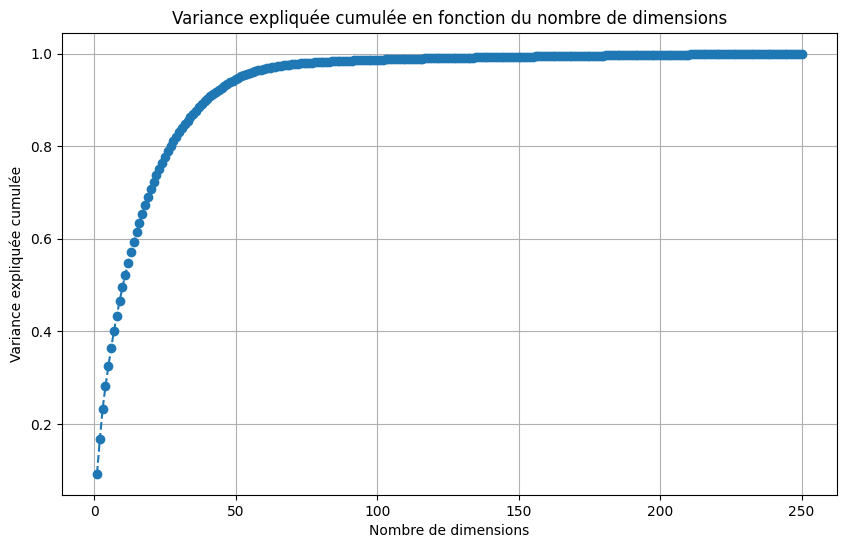

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 251), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Variance expliquée cumulée en fonction du nombre de dimensions')
plt.xlabel('Nombre de dimensions')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.show()

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
articles_emb_reduced = pca.fit_transform(articles_emb)

In [61]:
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Pourcentage d'explication de la variance conservée : {explained_variance * 100:.2f}%")

Pourcentage d'explication de la variance conservée : 94.53%


Passer de 250 dimensions à 50 dimensions permet d'alléger le fichier tout en gardant 95% de l'explication de la variance.  

In [62]:
import pickle

# Sauvegarder les embeddings réduits
with open('articles_embeddings_reduced_50.pickle', 'wb') as f:
    pickle.dump(articles_emb_reduced, f)

Avant de terminer, j'ai voulu regarder si notre fichier d'embedding réduit propose des résultats cohérent par rapport à l'embedding complet.  

In [63]:
# Convertir en DataFrame
articles_emb_reduced_df = pd.DataFrame(articles_emb_reduced, index=articles_emb.index)

In [64]:
import time

# Mesurer le temps d'exécution et afficher les résultats pour articles_emb
start_time = time.time()
recommended_articles_emb = recommend_articles_adj(user_id=20, n=5, embedding='articles_emb')
end_time = time.time()
execution_time_emb = end_time - start_time
print(f"Temps d'exécution pour articles_emb: {execution_time_emb} secondes")
print("Recommandations pour articles_emb:", recommended_articles_emb)

# Mesurer le temps d'exécution et afficher les résultats pour articles_emb_reduced
start_time = time.time()
recommended_articles_emb_reduced = recommend_articles_adj(user_id=20, n=5, embedding='articles_emb_reduced_df')
end_time = time.time()
execution_time_emb_reduced = end_time - start_time
print(f"Temps d'exécution pour articles_emb_reduced_df: {execution_time_emb_reduced} secondes")
print("Recommandations pour articles_emb_reduced_df:", recommended_articles_emb_reduced)

Temps d'exécution pour articles_emb: 15.119165658950806 secondes
Recommandations pour articles_emb: [158186, 162343, 157057, 154618, 160040]
Temps d'exécution pour articles_emb_reduced_df: 15.098707675933838 secondes
Recommandations pour articles_emb_reduced_df: [158186, 162343, 160040, 157057, 154618]


In [65]:
import time

# Mesurer le temps d'exécution et afficher les résultats pour articles_emb
start_time = time.time()
recommended_articles_emb = recommend_articles_adj(user_id=200, n=5, embedding='articles_emb')
end_time = time.time()
execution_time_emb = end_time - start_time
print(f"Temps d'exécution pour articles_emb: {execution_time_emb} secondes")
print("Recommandations pour articles_emb:", recommended_articles_emb)

# Mesurer le temps d'exécution et afficher les résultats pour articles_emb_reduced
start_time = time.time()
recommended_articles_emb_reduced = recommend_articles_adj(user_id=200, n=5, embedding='articles_emb_reduced_df')
end_time = time.time()
execution_time_emb_reduced = end_time - start_time
print(f"Temps d'exécution pour articles_emb_reduced_df: {execution_time_emb_reduced} secondes")
print("Recommandations pour articles_emb_reduced_df:", recommended_articles_emb_reduced)

Temps d'exécution pour articles_emb: 21.22710919380188 secondes
Recommandations pour articles_emb: [108853, 108966, 331737, 108847, 108810]
Temps d'exécution pour articles_emb_reduced_df: 15.315604448318481 secondes
Recommandations pour articles_emb_reduced_df: [108853, 108966, 108847, 331737, 108810]


In [66]:
import time

# Mesurer le temps d'exécution et afficher les résultats pour articles_emb
start_time = time.time()
recommended_articles_emb = recommend_articles_adj(user_id=1000, n=5, embedding='articles_emb')
end_time = time.time()
execution_time_emb = end_time - start_time
print(f"Temps d'exécution pour articles_emb: {execution_time_emb} secondes")
print("Recommandations pour articles_emb:", recommended_articles_emb)

# Mesurer le temps d'exécution et afficher les résultats pour articles_emb_reduced
start_time = time.time()
recommended_articles_emb_reduced = recommend_articles_adj(user_id=1000, n=5, embedding='articles_emb_reduced_df')
end_time = time.time()
execution_time_emb_reduced = end_time - start_time
print(f"Temps d'exécution pour articles_emb_reduced_df: {execution_time_emb_reduced} secondes")
print("Recommandations pour articles_emb_reduced_df:", recommended_articles_emb_reduced)

Temps d'exécution pour articles_emb: 15.30441927909851 secondes
Recommandations pour articles_emb: [284845, 331737, 216379, 332194, 118495]
Temps d'exécution pour articles_emb_reduced_df: 15.153097867965698 secondes
Recommandations pour articles_emb_reduced_df: [284845, 216379, 331737, 332194, 118614]


Les recommandations semblent être identique. Nous ne gagnons que quelques millisecondes de temps de calcul mais le fichiers est bien moins volumineux et plus facile à utiliser.  

Pour terminer, je sauvegarde le fichier clicks_df permettant de définir la matrice pour le modèle NMF.  

In [67]:
# Sauvegarder le clicks_df en local dans un fichier CSV
clicks_df.to_csv('clicks_df.csv', index=False)